# Analysis

In [157]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sentence_transformers import SentenceTransformer, util
import numpy as np

# load in "data_merged.csv" as a DataFrame called "data"
data = pd.read_csv("data_merged.csv")

## Analysis of titles

In [158]:

# Load your data
#df = pd.read_csv('your_dataset.csv')  # Replace with your actual file path
texts = data['title'].astype(str).tolist()

# Preprocess the text data
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Remove punctuation and numbers
    text = text.lower()  # Convert to lowercase
    tokens = text.split()  # Tokenize
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)

processed_texts = [preprocess_text(text) for text in texts]

# Vectorize the text data
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(processed_texts)


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


In [159]:

# Train the LDA model
lda = LatentDirichletAllocation(n_components=6, random_state=0)
lda.fit(dtm)

# Extract topics
def get_topics(model, vectorizer, top_n=10):
    words = vectorizer.get_feature_names_out()
    topics = {}
    for idx, topic in enumerate(model.components_):
        topics[f"Topic {idx + 1}"] = [words[i] for i in topic.argsort()[-top_n:]]
    return topics

topics = get_topics(lda, vectorizer)

# Get representative sentences
def get_representative_sentences(texts, model, dtm, num_sentences=2):
    representative_sentences = {}
    topic_distributions = model.transform(dtm)
    for idx, topic_dist in enumerate(topic_distributions):
        topic = topic_dist.argmax()
        if f"Topic {topic + 1}" not in representative_sentences:
            representative_sentences[f"Topic {topic + 1}"] = [texts[idx]]
        elif len(representative_sentences[f"Topic {topic + 1}"]) < num_sentences:
            representative_sentences[f"Topic {topic + 1}"].append(texts[idx])
    return representative_sentences

representative_sentences = get_representative_sentences(texts, lda, dtm)

# Use BERT embeddings to name topics
model = SentenceTransformer('all-MiniLM-L6-v2')

def generate_topic_names(keywords, model, num_names=5):
    embeddings = model.encode(keywords, convert_to_tensor=True)
    centroid = embeddings.mean(dim=0)
    cos_similarities = util.pytorch_cos_sim(centroid, embeddings)
    closest_idxs = cos_similarities.argsort(descending=True).flatten()[:num_names]
    return [keywords[idx] for idx in closest_idxs]

topic_names = {}
for topic, keywords in topics.items():
    topic_names[topic] = generate_topic_names(keywords, model, num_names=5)

# Generate results table
results = []
for topic, keywords in topics.items():
    results.append({
        'Topic': topic,
        'Topic Names': ', '.join(topic_names[topic]),
        'Keywords': ', '.join(keywords),
        'Representative Sentences': ' | '.join(representative_sentences[topic]),
    })

results_df = pd.DataFrame(results)
print(results_df)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


     Topic                                        Topic Names  \
0  Topic 1  understanding, visual, introduction, data, models   
1  Topic 2       brain, language, neuroscience, study, social   
2  Topic 3  coordination, development, mechanism, making, ...   
3  Topic 4     culture, social, research, emotional, cultures   
4  Topic 5           theory, models, structure, using, issues   
5  Topic 6   science, psychology, emotion, evolution, control   

                                            Keywords  \
0  cognition, data, architecture, understanding, ...   
1  neuroscience, study, memory, language, linear,...   
2  development, spiders, making, physiological, m...   
3  cultures, culture, using, research, emotional,...   
4  models, structure, issues, significance, testi...   
5  science, emotion, investigation, mechanisms, c...   

                            Representative Sentences  
0  Bridge Centrality: A Network Approach to Under...  
1  A network analysis of DSM-5 posttrauma

## Analysis of abstracts

In [160]:
# creating a list of possible topics
au_cogsci_list = ['Psychology', 'Neuroscience', 'Artificial Intelligence and Computer Science', 'Linguistics', 'Philosophy', 'Anthropology']
topic_list = ['Psychology', 'Neuroscience', 'Computer Science', 'Linguistics', 'Philosophy', 'Anthropology', 'Education', 'Mathematics', 'Statistics', 'Economics', 'Sociology', 'Biology', 'Medicine', 'Psychiatry', 'Neurology', 'Communication Studies']


In [161]:
# print the number of rows each Course has in the dataframe "data"
print(data['Course'].value_counts())


Social and Cultural dynamics         63
Methods                              44
Cognitive Neuroscience               20
Introduction to cognitive science    20
Perception & Action                  10
Philosophy of Cognitive Science      10
Applied Cognitive Science             7
Cognition and Communication           5
Name: Course, dtype: int64


Given the sheer amount of data from the social and cultural dynamics course compared to the other courses, we will trying removing 40 of the rows to even the playing field.

In [162]:
# printing the "course" value for the first 60 rows
print(data['Course'][:60])

# removing the first 35 rows from the dataframe "data"
data = data[35:]

0     Social and Cultural dynamics
1     Social and Cultural dynamics
2     Social and Cultural dynamics
3     Social and Cultural dynamics
4     Social and Cultural dynamics
5     Social and Cultural dynamics
6     Social and Cultural dynamics
7     Social and Cultural dynamics
8     Social and Cultural dynamics
9     Social and Cultural dynamics
10    Social and Cultural dynamics
11    Social and Cultural dynamics
12    Social and Cultural dynamics
13    Social and Cultural dynamics
14    Social and Cultural dynamics
15    Social and Cultural dynamics
16    Social and Cultural dynamics
17    Social and Cultural dynamics
18    Social and Cultural dynamics
19    Social and Cultural dynamics
20    Social and Cultural dynamics
21    Social and Cultural dynamics
22    Social and Cultural dynamics
23    Social and Cultural dynamics
24    Social and Cultural dynamics
25    Social and Cultural dynamics
26    Social and Cultural dynamics
27    Social and Cultural dynamics
28    Social and Cul

### Preprocessing the data


In [163]:

# Load your data
# df = pd.read_csv('your_dataset.csv')  # Replace with your actual file path
texts = data['abstract'].astype(str).tolist()

# Preprocess the text data
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Remove punctuation and numbers
    text = text.lower()  # Convert to lowercase
    tokens = text.split()  # Tokenize
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    # print(tokens)
    return ' '.join(tokens)


processed_texts = [preprocess_text(text) for text in texts]

# Vectorize the text data
vectorizer = CountVectorizer(max_df=0.95, min_df=5, stop_words='english')
dtm = vectorizer.fit_transform(processed_texts)


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


### Training the model

In [164]:

# Train the LDA model
lda = LatentDirichletAllocation(n_components=6, random_state=0)
lda.fit(dtm)

# Extract topics
def get_topics(model, vectorizer, top_n=10):
    words = vectorizer.get_feature_names_out()
    topics = {}
    for idx, topic in enumerate(model.components_):
        topics[f"Topic {idx + 1}"] = [words[i] for i in topic.argsort()[-top_n:]]
    return topics

topics = get_topics(lda, vectorizer)


### Getting topic names

In [165]:

# Get representative sentences
def get_representative_sentences(texts, model, dtm, num_sentences=3):
    representative_sentences = {}
    topic_distributions = model.transform(dtm)
    for idx, topic_dist in enumerate(topic_distributions):
        topic = topic_dist.argmax()
        if f"Topic {topic + 1}" not in representative_sentences:
            representative_sentences[f"Topic {topic + 1}"] = [texts[idx]]
        elif len(representative_sentences[f"Topic {topic + 1}"]) < num_sentences:
            representative_sentences[f"Topic {topic + 1}"].append(texts[idx])
    return representative_sentences

representative_sentences = get_representative_sentences(texts, lda, dtm)

# Use BERT embeddings to name topics
model = SentenceTransformer('all-MiniLM-L6-v2')

def generate_topic_names(keywords, representative_sentences, model, num_names=5):
    combined_text = keywords + representative_sentences
    embeddings = model.encode(combined_text, convert_to_tensor=True)
    centroid = embeddings.mean(dim=0)
    cos_similarities = util.pytorch_cos_sim(centroid, embeddings)
    closest_idxs = cos_similarities.argsort(descending=True).flatten()[:num_names]
    return [combined_text[idx] for idx in closest_idxs]

# Ensure unique topic names
def ensure_unique_names(topic_names):
    seen = set()
    unique_names = []
    for names in topic_names:
        for name in names:
            if name not in seen:
                seen.add(name)
                unique_names.append(name)
                break
    return unique_names

topic_names = {}
for topic, keywords in topics.items():
    representative_text = ' '.join(representative_sentences[topic])
    topic_names[topic] = generate_topic_names(keywords, [representative_text], model, num_names=5)

unique_topic_names = ensure_unique_names(topic_names.values())

# Generate results table
results = []
for i, (topic, keywords) in enumerate(topics.items()):
    results.append({
        'Topic': topic,
        'Topic Names': ', '.join(topic_names[topic]),
        'Unique Topic Name': unique_topic_names[i],
        'Keywords': ', '.join(keywords),
        'Representative Sentences': ' | '.join(representative_sentences[topic]),
    })

results_df = pd.DataFrame(results)
print(results_df)



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


     Topic                                       Topic Names  \
0  Topic 1       research, studies, results, data, inference   
1  Topic 2  perception, stimuli, action, information, visual   
2  Topic 3        neural, brain, neurons, sensory, attention   
3  Topic 4           memory, language, brain, data, research   
4  Topic 5               model, models, data, value, chapter   
5  Topic 6          groups, group, networks, social, network   

  Unique Topic Name                                           Keywords  \
0          research  recent, studies, data, causal, active, psychol...   
1        perception  effects, stimuli, emotional, data, evidence, p...   
2            neural  motor, neurons, information, activity, systems...   
3            memory  memories, interaction, based, research, use, h...   
4             model  value, variables, introduced, psychology, line...   
5            groups  used, groups, group, coordination, methods, ne...   

                            Repr

In [166]:
# print the keywords column from results_df
print(results_df['Representative Sentences'][0])


nan | We present the fundamental ideas underlying statistical hypothesis testing using the frequentist framework. We start with a simple example that builds up the one-sample t-test from the beginning, explaining important concepts such as the sampling distribution of the sample mean, and the iid assumption. Then, we examine the meaning of the p-value in detail and discuss several important misconceptions about what a p-value does and does not tell us. This leads to a discussion of Type I, II error and power, and Type S and M error. An important conclusion from this discussion is that one should aim to carry out appropriately powered studies. Next, we discuss two common issues that we have encountered in psycholinguistics and linguistics: running experiments until significance is reached and the ‘garden-of-forking-paths’ problem discussed by Gelman and others. The best way to use frequentist methods is to run appropriately powered studies, check model assumptions, clearly separate expl

### Comparing topic similarity to predefined topics 

In [167]:
# Function to calculate similarity scores for a topic list
def calculate_similarity_scores(topic_list, representative_sentences, model):
    scores = []
    for topic in topic_list:
        topic_embedding = model.encode(topic, convert_to_tensor=True)
        topic_scores = []
        for sentence_list in representative_sentences.values():
            for sentence in sentence_list:
                sentence_embedding = model.encode(sentence, convert_to_tensor=True).unsqueeze(0)  # Ensure sentence_embedding is 2D
                score = util.pytorch_cos_sim(topic_embedding, sentence_embedding).item()
                topic_scores.append(score)
        avg_score = np.mean(topic_scores)
        scores.append((topic, avg_score))
    return scores

# Calculate similarity scores for each topic list
au_cogsci_scores = calculate_similarity_scores(au_cogsci_list, representative_sentences, model)
topic_list_scores = calculate_similarity_scores(topic_list, representative_sentences, model)


# Function to get top N topics by similarity score
def get_top_n_topics(scores, n=6):
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    return sorted_scores[:n]

# Get top 6 topics for each list
top_au_cogsci = get_top_n_topics(au_cogsci_scores)
top_topic_list = get_top_n_topics(topic_list_scores)


topic_names = []
score_list = []
# Print top 6 topics for each list
print("Top 6 topics for au_cogsci_list:")
for topic, score in top_au_cogsci:
    topic_names.append(topic)
    score_list.append(score)
    print(f"{topic}: {score}")
ex_topic_names = []
ex_score_list = []
print("\nTop 6 topics for topic_list:")
for topic, score in top_topic_list:
    ex_topic_names.append(topic)
    ex_score_list.append(score)
    print(f"{topic}: {score}")

# get top 8 topics for each list
#top_au_cogsci = get_top_n_topics(au_cogsci_scores) # we are not doing this with this list as it only has 6 topics
top_topic_list = get_top_n_topics(topic_list_scores, n=8)


# Print top 6 topics for each list
# print("Top 6 topics for au_cogsci_list:")
# for topic, score in top_au_cogsci:
#     print(f"{topic}: {score}")

print("\nTop 8 topics for topic_list:")
for topic, score in top_topic_list:
    print(f"{topic}: {score}")


Top 6 topics for au_cogsci_list:
Psychology: 0.21519978178872
Anthropology: 0.2114981644683414
Neuroscience: 0.21060542896803883
Linguistics: 0.1800282278822528
Artificial Intelligence and Computer Science: 0.14118977739579147
Philosophy: 0.1316481236782339

Top 6 topics for topic_list:
Psychology: 0.21519978178872
Anthropology: 0.2114981644683414
Neuroscience: 0.21060542896803883
Linguistics: 0.1800282278822528
Sociology: 0.17816975940432814
Communication Studies: 0.17445103699962297

Top 8 topics for topic_list:
Psychology: 0.21519978178872
Anthropology: 0.2114981644683414
Neuroscience: 0.21060542896803883
Linguistics: 0.1800282278822528
Sociology: 0.17816975940432814
Communication Studies: 0.17445103699962297
Biology: 0.16541557728002468
Statistics: 0.14254829432401392


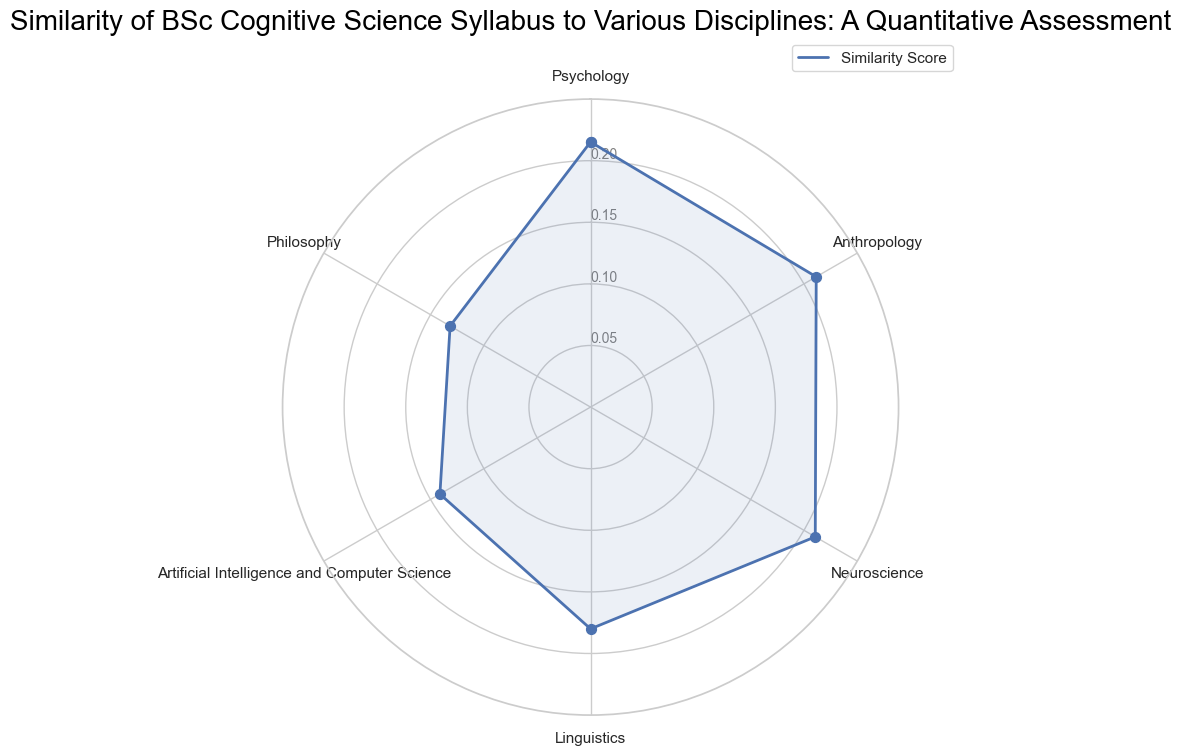

In [169]:
import matplotlib.pyplot as plt

# Create DataFrame
df = pd.DataFrame({
    'topic': topic_names,
    'score': score_list
})

ex_df = pd.DataFrame({
    'topic': ex_topic_names,
    'score': ex_score_list
})

# Number of variables
num_vars = len(df)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

# Initialize the radar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Draw one axe per variable and add labels
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Draw the outline of our data
ax.set_rlabel_position(0)

# Add topic labels
plt.xticks(angles[:-1], df['topic'])

# Add y-labels
ax.yaxis.set_tick_params(labelsize=10)
plt.yticks([0.05, 0.1, 0.15, 0.2], ["0.05", "0.10", "0.15", "0.20"], color="grey", size=10)
plt.ylim(0, 0.25)

# Plot data
values = df['score'].tolist()
values += values[:1]
ax.plot(angles, values, linewidth=2, linestyle='solid', label='Similarity Score')

# Add points
ax.scatter(angles, values, color='b', s=50, zorder=10)

# Fill area
ax.fill(angles, values, 'b', alpha=0.1)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

# Show the radar chart
plt.title('Similarity of BSc Cognitive Science Syllabus to Various Disciplines: A Quantitative Assessment', size=20, color='black', y=1.1)
plt.show()

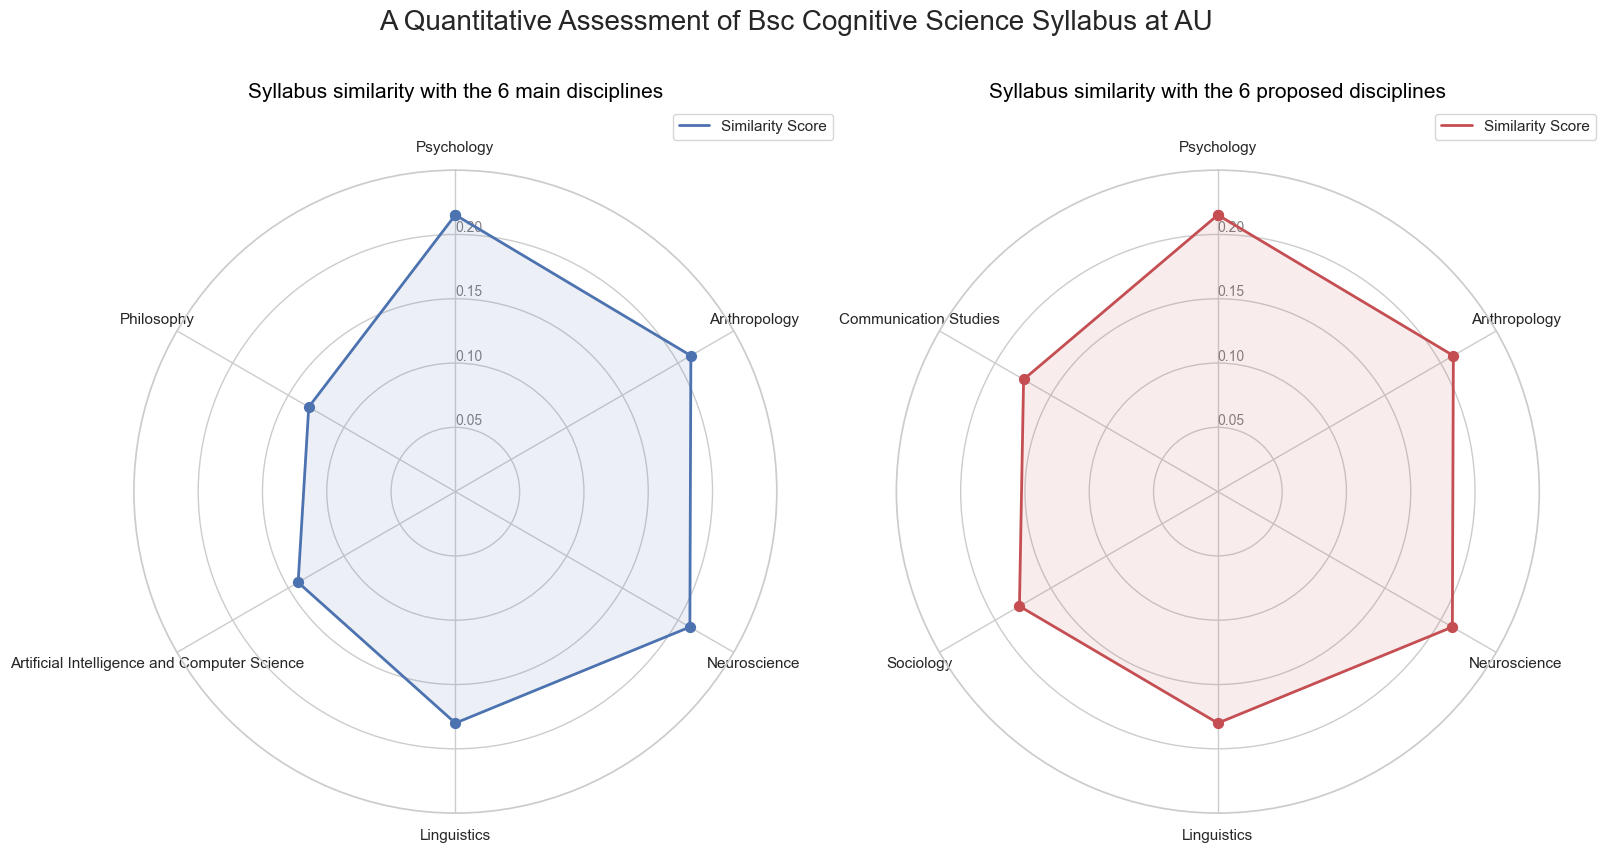

In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create DataFrames
df = pd.DataFrame({
    'topic': topic_names,
    'score': score_list
})

ex_df = pd.DataFrame({
    'topic': ex_topic_names,
    'score': ex_score_list
})

# Number of variables
num_vars = len(df)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

# Initialize the radar plots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), subplot_kw=dict(polar=True))

# Function to create radar chart
def create_radar_chart(ax, data, title, color):
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)

    # Add topic labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(data['topic'])

    # Add y-labels
    ax.yaxis.set_tick_params(labelsize=10)
    ax.set_yticks([0.05, 0.1, 0.15, 0.2])
    ax.set_yticklabels(["0.05", "0.10", "0.15", "0.20"], color="grey", size=10)
    ax.set_ylim(0, 0.25)

    # Plot data
    values = data['score'].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label='Similarity Score', color=color)
    
    # Add points
    ax.scatter(angles, values, color=color, s=50, zorder=10)
    
    # Fill area
    ax.fill(angles, values, color, alpha=0.1)

    # Add legend
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

    # Set title
    ax.set_title(title, size=15, color='black', y=1.1)

# Create radar charts
create_radar_chart(ax1, df, 'Syllabus similarity with the 6 main disciplines', 'b')
create_radar_chart(ax2, ex_df, 'Syllabus similarity with the 6 proposed disciplines','r')

# Add overarching title
fig.suptitle('A Quantitative Assessment of Bsc Cognitive Science Syllabus at AU', size=20, y=1.05)

# Adjust layout to make room for the super title
fig.tight_layout(pad=0.5)

# Show the radar charts
plt.show()


# Per course topic modelling: 

In [30]:
# print the names of the values in "course" column
print(data['Course'].unique())

courses = data['Course'].unique()

['Social and Cultural dynamics' 'Cognitive Neuroscience'
 'Perception & Action' 'Methods' 'Cognition and Communication'
 'Introduction to cognitive science' 'Applied Cognitive Science'
 'Philosophy of Cognitive Science']


In [31]:
## making a list of abstracts for these courses: 'Social and Cultural dynamics', 'Cognitive Neuroscience', 'Perception & Action', 'Methods', 'Cognition and Communication', 'Introduction to cognitive science', 'Applied Cognitive Science', 'Philosophy of Cognitive Science'
# make a list of abstracts for social and cultural dynamics
social_cultural_abstracts = data[data['Course'] == 'Social and Cultural dynamics']['abstract'].astype(str).tolist()

# make a list of abstracts for Methods
methods_abstracts = data[data['Course'] == 'Methods']['abstract'].astype(str).tolist()

# make a list of abstracts for Cognitive Neuroscience
cognitive_neuroscience_abstracts = data[data['Course'] == 'Cognitive Neuroscience']['abstract'].astype(str).tolist()

# make a list of abstracts for Introduction to Cognitive Science
intro_cogsci_abstracts = data[data['Course'] == 'Introduction to cognitive science']['abstract'].astype(str).tolist()

# make a list of abstracts for Philosophy of Cognitive Science
philosophy_cogsci_abstracts = data[data['Course'] == 'Philosophy of Cognitive Science']['abstract'].astype(str).tolist()

# make a list of abstracts for Perception & Action
perception_action_abstracts = data[data['Course'] == 'Perception & Action']['abstract'].astype(str).tolist()

# make a list of abstracts for Cognition and Communication
cognition_communication_abstracts = data[data['Course'] == 'Cognition and Communication']['abstract'].astype(str).tolist()

# make a list of abstracts for Applied Cognitive Science
applied_cogsci_abstracts = data[data['Course'] == 'Applied Cognitive Science']['abstract'].astype(str).tolist()




### Social and cultural dynamics


In [32]:
# Preprocess the text data
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Remove punctuation and numbers
    text = text.lower()  # Convert to lowercase
    tokens = text.split()  # Tokenize
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)

processed_texts = [preprocess_text(text) for text in social_cultural_abstracts]

# Vectorize the text data
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(processed_texts)

# Train the LDA model
lda = LatentDirichletAllocation(n_components=6, random_state=0)
lda.fit(dtm)

# Extract topics
def get_topics(model, vectorizer, top_n=10):
    words = vectorizer.get_feature_names_out()
    topics = {}
    for idx, topic in enumerate(model.components_):
        topics[f"Topic {idx + 1}"] = [words[i] for i in topic.argsort()[-top_n:]]
    return topics

topics = get_topics(lda, vectorizer)


# Get representative sentences
def get_representative_sentences(texts, model, dtm, num_sentences=3):
    representative_sentences = {}
    topic_distributions = model.transform(dtm)
    for idx, topic_dist in enumerate(topic_distributions):
        topic = topic_dist.argmax()
        if f"Topic {topic + 1}" not in representative_sentences:
            representative_sentences[f"Topic {topic + 1}"] = [texts[idx]]
        elif len(representative_sentences[f"Topic {topic + 1}"]) < num_sentences:
            representative_sentences[f"Topic {topic + 1}"].append(texts[idx])
    return representative_sentences

representative_sentences = get_representative_sentences(social_cultural_abstracts, lda, dtm)

# Use BERT embeddings to name topics
model = SentenceTransformer('all-MiniLM-L6-v2')

def generate_topic_names(keywords, representative_sentences, model, num_names=5):
    combined_text = keywords + representative_sentences
    embeddings = model.encode(combined_text, convert_to_tensor=True)
    centroid = embeddings.mean(dim=0)
    cos_similarities = util.pytorch_cos_sim(centroid, embeddings)
    closest_idxs = cos_similarities.argsort(descending=True).flatten()[:num_names]
    return [combined_text[idx] for idx in closest_idxs]

# Ensure unique topic names
def ensure_unique_names(topic_names):
    seen = set()
    unique_names = []
    for names in topic_names:
        for name in names:
            if name not in seen:
                seen.add(name)
                unique_names.append(name)
                break
    return unique_names

topic_names = {}
for topic, keywords in topics.items():
    representative_text = ' '.join(representative_sentences[topic])
    topic_names[topic] = generate_topic_names(keywords, [representative_text], model, num_names=5)

unique_topic_names = ensure_unique_names(topic_names.values())

# Generate results table
results = []
for i, (topic, keywords) in enumerate(topics.items()):
    results.append({
        'Topic': topic,
        'Topic Names': ', '.join(topic_names[topic]),
        'Unique Topic Name': unique_topic_names[i],
        'Keywords': ', '.join(keywords),
        'Representative Sentences': ' | '.join(representative_sentences[topic]),
    })

results_df = pd.DataFrame(results)
print(results_df)

# Function to calculate similarity scores for a topic list
def calculate_similarity_scores(topic_list, representative_sentences, model):
    scores = []
    for topic in topic_list:
        topic_embedding = model.encode(topic, convert_to_tensor=True)
        topic_scores = []
        for sentence_list in representative_sentences.values():
            for sentence in sentence_list:
                sentence_embedding = model.encode(sentence, convert_to_tensor=True).unsqueeze(0)  # Ensure sentence_embedding is 2D
                score = util.pytorch_cos_sim(topic_embedding, sentence_embedding).item()
                topic_scores.append(score)
        avg_score = np.mean(topic_scores)
        scores.append((topic, avg_score))
    return scores

# Calculate similarity scores for each topic list
au_cogsci_scores = calculate_similarity_scores(au_cogsci_list, representative_sentences, model)
topic_list_scores = calculate_similarity_scores(topic_list, representative_sentences, model)
extended_topic_list_scores = calculate_similarity_scores(extended_topic_list, representative_sentences, model)

# Function to get top N topics by similarity score
def get_top_n_topics(scores, n=6):
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    return sorted_scores[:n]

# Get top 6 topics for each list
top_au_cogsci = get_top_n_topics(au_cogsci_scores)
top_topic_list = get_top_n_topics(topic_list_scores)
top_extended_topic_list = get_top_n_topics(extended_topic_list_scores)

topic_names = []
score_list = []
# Print top 6 topics for each list
print("Top 6 topics for au_cogsci_list:")
for topic, score in top_au_cogsci:
    topic_names.append(topic)
    score_list.append(score)
    print(f"{topic}: {score}")

print("\nTop 6 topics for topic_list:")
for topic, score in top_topic_list:
    print(f"{topic}: {score}")

print("\nTop 6 topics for extended_topic_list:")
for topic, score in top_extended_topic_list:
    print(f"{topic}: {score}")

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


     Topic                                        Topic Names  \
0  Topic 1        networks, learning, social, systems, bridge   
1  Topic 2         game, social, results, groups, information   
2  Topic 3            web, webs, search, information, present   
3  Topic 4  social, collective, individuals, diversity, cu...   
4  Topic 5     networks, individuals, network, models, social   
5  Topic 6      networks, network, complex, structure, social   

  Unique Topic Name                                           Keywords  \
0          networks  methods, evolution, time, cumulative, bridge, ...   
1              game  results, analysis, evolve, fairness, treatment...   
2               web  exploration, attention, web, cognitive, new, s...   
3            social  interaction, collective, performance, evolutio...   
4       individuals  individuals, models, personality, individual, ...   
5           network  possible, paths, method, complex, structure, s...   

                         

In [33]:
# Create DataFrame
soical_df = pd.DataFrame({
    'topic': topic_names,
    'score': score_list,
    'course': "Social and Cultural dynamics"
})


### Cognitive neuroscience

In [34]:
# Preprocess the text data
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Remove punctuation and numbers
    text = text.lower()  # Convert to lowercase
    tokens = text.split()  # Tokenize
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)

processed_texts = [preprocess_text(text) for text in cognitive_neuroscience_abstracts]

# Vectorize the text data
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(processed_texts)

# Train the LDA model
lda = LatentDirichletAllocation(n_components=6, random_state=0)
lda.fit(dtm)

# Extract topics
def get_topics(model, vectorizer, top_n=10):
    words = vectorizer.get_feature_names_out()
    topics = {}
    for idx, topic in enumerate(model.components_):
        topics[f"Topic {idx + 1}"] = [words[i] for i in topic.argsort()[-top_n:]]
    return topics

topics = get_topics(lda, vectorizer)


# Get representative sentences
def get_representative_sentences(texts, model, dtm, num_sentences=3):
    representative_sentences = {}
    topic_distributions = model.transform(dtm)
    for idx, topic_dist in enumerate(topic_distributions):
        topic = topic_dist.argmax()
        if f"Topic {topic + 1}" not in representative_sentences:
            representative_sentences[f"Topic {topic + 1}"] = [texts[idx]]
        elif len(representative_sentences[f"Topic {topic + 1}"]) < num_sentences:
            representative_sentences[f"Topic {topic + 1}"].append(texts[idx])
    return representative_sentences

representative_sentences = get_representative_sentences(cognitive_neuroscience_abstracts, lda, dtm)

# Use BERT embeddings to name topics
model = SentenceTransformer('all-MiniLM-L6-v2')

def generate_topic_names(keywords, representative_sentences, model, num_names=5):
    combined_text = keywords + representative_sentences
    embeddings = model.encode(combined_text, convert_to_tensor=True)
    centroid = embeddings.mean(dim=0)
    cos_similarities = util.pytorch_cos_sim(centroid, embeddings)
    closest_idxs = cos_similarities.argsort(descending=True).flatten()[:num_names]
    return [combined_text[idx] for idx in closest_idxs]

# Ensure unique topic names
def ensure_unique_names(topic_names):
    seen = set()
    unique_names = []
    for names in topic_names:
        for name in names:
            if name not in seen:
                seen.add(name)
                unique_names.append(name)
                break
    return unique_names

topic_names = {}
for topic, keywords in topics.items():
    representative_text = ' '.join(representative_sentences[topic])
    topic_names[topic] = generate_topic_names(keywords, [representative_text], model, num_names=5)

unique_topic_names = ensure_unique_names(topic_names.values())

# Generate results table
results = []
for i, (topic, keywords) in enumerate(topics.items()):
    results.append({
        'Topic': topic,
        'Topic Names': ', '.join(topic_names[topic]),
        'Unique Topic Name': unique_topic_names[i],
        'Keywords': ', '.join(keywords),
        'Representative Sentences': ' | '.join(representative_sentences[topic]),
    })

results_df = pd.DataFrame(results)
print(results_df)

# Function to calculate similarity scores for a topic list
def calculate_similarity_scores(topic_list, representative_sentences, model):
    scores = []
    for topic in topic_list:
        topic_embedding = model.encode(topic, convert_to_tensor=True)
        topic_scores = []
        for sentence_list in representative_sentences.values():
            for sentence in sentence_list:
                sentence_embedding = model.encode(sentence, convert_to_tensor=True).unsqueeze(0)  # Ensure sentence_embedding is 2D
                score = util.pytorch_cos_sim(topic_embedding, sentence_embedding).item()
                topic_scores.append(score)
        avg_score = np.mean(topic_scores)
        scores.append((topic, avg_score))
    return scores

# Calculate similarity scores for each topic list
au_cogsci_scores = calculate_similarity_scores(au_cogsci_list, representative_sentences, model)
topic_list_scores = calculate_similarity_scores(topic_list, representative_sentences, model)
extended_topic_list_scores = calculate_similarity_scores(extended_topic_list, representative_sentences, model)

# Function to get top N topics by similarity score
def get_top_n_topics(scores, n=6):
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    return sorted_scores[:n]

# Get top 6 topics for each list
top_au_cogsci = get_top_n_topics(au_cogsci_scores)
top_topic_list = get_top_n_topics(topic_list_scores)
top_extended_topic_list = get_top_n_topics(extended_topic_list_scores)
topic_names = []
score_list = []
# Print top 6 topics for each list
print("Top 6 topics for au_cogsci_list:")
for topic, score in top_au_cogsci:
    topic_names.append(topic)
    score_list.append(score)
    print(f"{topic}: {score}")

print("\nTop 6 topics for topic_list:")
for topic, score in top_topic_list:
    print(f"{topic}: {score}")

print("\nTop 6 topics for extended_topic_list:")
for topic, score in top_extended_topic_list:
    print(f"{topic}: {score}")

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


     Topic                                     Topic Names Unique Topic Name  \
0  Topic 1    neurons, structure, axon, proteins, membrane           neurons   
1  Topic 2      cortex, stimuli, neurons, activity, visual            cortex   
2  Topic 3      brain, memory, activity, studies, language             brain   
3  Topic 4       neural, sensory, control, cortical, motor            neural   
4  Topic 5  memory, brain, memories, synaptic, information            memory   
5  Topic 6       brain, neurons, cortex, auditory, sensory          auditory   

                                            Keywords  \
0  work, function, site, terminal, membrane, info...   
1  cortex, left, neurons, pathways, motor, reduce...   
2  areas, functions, human, imaging, studies, act...   
3  function, control, spinal, sensory, neural, vi...   
4  information, membrane, action, transmission, m...   
5  cortex, different, inputs, neurons, brain, cha...   

                            Representative Sen

### Making radar chart

In [35]:
# Create DataFrame
neuro_df = pd.DataFrame({
    'topic': topic_names,
    'score': score_list,
    'course': "Cognitive Neuroscience"
})


### Perception & Action


In [36]:
# Preprocess the text data
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Remove punctuation and numbers
    text = text.lower()  # Convert to lowercase
    tokens = text.split()  # Tokenize
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)

processed_texts = [preprocess_text(text) for text in perception_action_abstracts]

# Vectorize the text data
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(processed_texts)

# Train the LDA model
lda = LatentDirichletAllocation(n_components=2, random_state=0)
lda.fit(dtm)

# Extract topics
def get_topics(model, vectorizer, top_n=10):
    words = vectorizer.get_feature_names_out()
    topics = {}
    for idx, topic in enumerate(model.components_):
        topics[f"Topic {idx + 1}"] = [words[i] for i in topic.argsort()[-top_n:]]
    return topics

topics = get_topics(lda, vectorizer)


# Get representative sentences
def get_representative_sentences(texts, model, dtm, num_sentences=3):
    representative_sentences = {}
    topic_distributions = model.transform(dtm)
    for idx, topic_dist in enumerate(topic_distributions):
        topic = topic_dist.argmax()
        if f"Topic {topic + 1}" not in representative_sentences:
            representative_sentences[f"Topic {topic + 1}"] = [texts[idx]]
        elif len(representative_sentences[f"Topic {topic + 1}"]) < num_sentences:
            representative_sentences[f"Topic {topic + 1}"].append(texts[idx])
    return representative_sentences

representative_sentences = get_representative_sentences(perception_action_abstracts, lda, dtm)

# Use BERT embeddings to name topics
model = SentenceTransformer('all-MiniLM-L6-v2')

def generate_topic_names(keywords, representative_sentences, model, num_names=5):
    combined_text = keywords + representative_sentences
    embeddings = model.encode(combined_text, convert_to_tensor=True)
    centroid = embeddings.mean(dim=0)
    cos_similarities = util.pytorch_cos_sim(centroid, embeddings)
    closest_idxs = cos_similarities.argsort(descending=True).flatten()[:num_names]
    return [combined_text[idx] for idx in closest_idxs]

# Ensure unique topic names
def ensure_unique_names(topic_names):
    seen = set()
    unique_names = []
    for names in topic_names:
        for name in names:
            if name not in seen:
                seen.add(name)
                unique_names.append(name)
                break
    return unique_names

topic_names = {}
for topic, keywords in topics.items():
    # Check if the topic is in the representative_sentences dictionary
    if topic in representative_sentences:
        representative_text = ' '.join(representative_sentences[topic])
        topic_names[topic] = generate_topic_names(keywords, [representative_text], model, num_names=5)
    else:
        print(f"Warning: No representative sentences found for {topic}. Skipping.")
        topic_names[topic] = ["No data available"]

unique_topic_names = ensure_unique_names(topic_names.values())

# Generate results table
results = []
for i, (topic, keywords) in enumerate(topics.items()):
    results.append({
        'Topic': topic,
        'Topic Names': ', '.join(topic_names[topic]),
        'Unique Topic Name': unique_topic_names[i],
        'Keywords': ', '.join(keywords),
        'Representative Sentences': ' | '.join(representative_sentences[topic]),
    })

results_df = pd.DataFrame(results)
print(results_df)

# Function to calculate similarity scores for a topic list
def calculate_similarity_scores(topic_list, representative_sentences, model):
    scores = []
    for topic in topic_list:
        topic_embedding = model.encode(topic, convert_to_tensor=True)
        topic_scores = []
        for sentence_list in representative_sentences.values():
            for sentence in sentence_list:
                sentence_embedding = model.encode(sentence, convert_to_tensor=True).unsqueeze(0)  # Ensure sentence_embedding is 2D
                score = util.pytorch_cos_sim(topic_embedding, sentence_embedding).item()
                topic_scores.append(score)
        avg_score = np.mean(topic_scores)
        scores.append((topic, avg_score))
    return scores

# Calculate similarity scores for each topic list
au_cogsci_scores = calculate_similarity_scores(au_cogsci_list, representative_sentences, model)
topic_list_scores = calculate_similarity_scores(topic_list, representative_sentences, model)
extended_topic_list_scores = calculate_similarity_scores(extended_topic_list, representative_sentences, model)

# Function to get top N topics by similarity score
def get_top_n_topics(scores, n=6):
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    return sorted_scores[:n]

# Get top 6 topics for each list
top_au_cogsci = get_top_n_topics(au_cogsci_scores)
top_topic_list = get_top_n_topics(topic_list_scores)
top_extended_topic_list = get_top_n_topics(extended_topic_list_scores)
topic_names = []
score_list = []
# Print top 6 topics for each list
print("Top 6 topics for au_cogsci_list:")
for topic, score in top_au_cogsci:
    topic_names.append(topic)
    score_list.append(score)
    print(f"{topic}: {score}")

print("\nTop 6 topics for topic_list:")
for topic, score in top_topic_list:
    print(f"{topic}: {score}")

print("\nTop 6 topics for extended_topic_list:")
for topic, score in top_extended_topic_list:
    print(f"{topic}: {score}")

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


     Topic                                     Topic Names Unique Topic Name  \
0  Topic 1    actions, action, perception, sensory, neural           actions   
1  Topic 2  perception, action, brain, information, theory        perception   

                                            Keywords  \
0  psychology, human, control, include, actions, ...   
1  information, brain, ways, action, model, speci...   

                            Representative Sentences  
0  This textbook provides a comprehensive introdu...  
1  Over the past decade, mouse tracking in choice...  
Top 6 topics for au_cogsci_list:
Psychology: 0.3139771014451981
Neuroscience: 0.3035599946975708
Artificial Intelligence and Computer Science: 0.13865616768598557
Anthropology: 0.1304582342505455
Philosophy: 0.10626321360468864
Linguistics: 0.0937790997326374

Top 6 topics for topic_list:
Psychology: 0.3139771014451981
Neuroscience: 0.3035599946975708
Artificial Intelligence: 0.19536586701869965
Anthropology: 0.1304582342

In [37]:
# Create DataFrame
perception_df = pd.DataFrame({
    'topic': topic_names,
    'score': score_list,
    'course': "Perception & Action"
})


### Methods

In [38]:
processed_texts = [preprocess_text(text) for text in methods_abstracts]

# Vectorize the text data
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(processed_texts)

# Train the LDA model
lda = LatentDirichletAllocation(n_components=6, random_state=0)
lda.fit(dtm)

# Extract topics
def get_topics(model, vectorizer, top_n=10):
    words = vectorizer.get_feature_names_out()
    topics = {}
    for idx, topic in enumerate(model.components_):
        topics[f"Topic {idx + 1}"] = [words[i] for i in topic.argsort()[-top_n:]]
    return topics

topics = get_topics(lda, vectorizer)


# Get representative sentences
def get_representative_sentences(texts, model, dtm, num_sentences=3):
    representative_sentences = {}
    topic_distributions = model.transform(dtm)
    for idx, topic_dist in enumerate(topic_distributions):
        topic = topic_dist.argmax()
        if f"Topic {topic + 1}" not in representative_sentences:
            representative_sentences[f"Topic {topic + 1}"] = [texts[idx]]
        elif len(representative_sentences[f"Topic {topic + 1}"]) < num_sentences:
            representative_sentences[f"Topic {topic + 1}"].append(texts[idx])
    return representative_sentences

representative_sentences = get_representative_sentences(methods_abstracts, lda, dtm)

# Use BERT embeddings to name topics
model = SentenceTransformer('all-MiniLM-L6-v2')

def generate_topic_names(keywords, representative_sentences, model, num_names=5):
    combined_text = keywords + representative_sentences
    embeddings = model.encode(combined_text, convert_to_tensor=True)
    centroid = embeddings.mean(dim=0)
    cos_similarities = util.pytorch_cos_sim(centroid, embeddings)
    closest_idxs = cos_similarities.argsort(descending=True).flatten()[:num_names]
    return [combined_text[idx] for idx in closest_idxs]

# Ensure unique topic names
def ensure_unique_names(topic_names):
    seen = set()
    unique_names = []
    for names in topic_names:
        for name in names:
            if name not in seen:
                seen.add(name)
                unique_names.append(name)
                break
    return unique_names

topic_names = {}
for topic, keywords in topics.items():
    representative_text = ' '.join(representative_sentences[topic])
    topic_names[topic] = generate_topic_names(keywords, [representative_text], model, num_names=5)

unique_topic_names = ensure_unique_names(topic_names.values())

# Generate results table
results = []
for i, (topic, keywords) in enumerate(topics.items()):
    results.append({
        'Topic': topic,
        'Topic Names': ', '.join(topic_names[topic]),
        'Unique Topic Name': unique_topic_names[i],
        'Keywords': ', '.join(keywords),
        'Representative Sentences': ' | '.join(representative_sentences[topic]),
    })

results_df = pd.DataFrame(results)
print(results_df)

# Function to calculate similarity scores for a topic list
def calculate_similarity_scores(topic_list, representative_sentences, model):
    scores = []
    for topic in topic_list:
        topic_embedding = model.encode(topic, convert_to_tensor=True)
        topic_scores = []
        for sentence_list in representative_sentences.values():
            for sentence in sentence_list:
                sentence_embedding = model.encode(sentence, convert_to_tensor=True).unsqueeze(0)  # Ensure sentence_embedding is 2D
                score = util.pytorch_cos_sim(topic_embedding, sentence_embedding).item()
                topic_scores.append(score)
        avg_score = np.mean(topic_scores)
        scores.append((topic, avg_score))
    return scores

# Calculate similarity scores for each topic list
au_cogsci_scores = calculate_similarity_scores(au_cogsci_list, representative_sentences, model)
topic_list_scores = calculate_similarity_scores(topic_list, representative_sentences, model)
extended_topic_list_scores = calculate_similarity_scores(extended_topic_list, representative_sentences, model)

# Function to get top N topics by similarity score
def get_top_n_topics(scores, n=6):
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    return sorted_scores[:n]

# Get top 6 topics for each list
top_au_cogsci = get_top_n_topics(au_cogsci_scores)
top_topic_list = get_top_n_topics(topic_list_scores)
top_extended_topic_list = get_top_n_topics(extended_topic_list_scores)
topic_names = []
score_list = []
# Print top 6 topics for each list
print("Top 6 topics for au_cogsci_list:")
for topic, score in top_au_cogsci:
    topic_names.append(topic)
    score_list.append(score)
    print(f"{topic}: {score}")

print("\nTop 6 topics for topic_list:")
for topic, score in top_topic_list:
    print(f"{topic}: {score}")

print("\nTop 6 topics for extended_topic_list:")
for topic, score in top_extended_topic_list:
    print(f"{topic}: {score}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


     Topic                                        Topic Names  \
0  Topic 1             model, models, chapter, chapters, data   
1  Topic 2  research, analysis, interaction, interactions,...   
2  Topic 3  variables, data, correlation, relationships, l...   
3  Topic 4              model, models, data, chapter, effects   
4  Topic 5      models, predictors, predictor, modeling, data   
5  Topic 6            model, models, using, data, performance   

  Unique Topic Name                                           Keywords  \
0             model  linguistic, distribution, schizophrenia, gener...   
1          research  data, important, analysis, hypotheses, errors,...   
2         variables  probability, transformations, relationships, c...   
3            models  chapter, using, model, posterior, effects, soc...   
4        predictors  coordination, predictor, modeling, sample, pre...   
5             using  introduced, trials, performance, regression, u...   

                         

In [39]:
# Create DataFrame
methods_df = pd.DataFrame({
    'topic': topic_names,
    'score': score_list,
    'course': "Methods"
})


### Cognition and Communication 

In [43]:
processed_texts = [preprocess_text(text) for text in cognition_communication_abstracts]

# Vectorize the text data
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(processed_texts)

# Train the LDA model
lda = LatentDirichletAllocation(n_components=2, random_state=0)
lda.fit(dtm)

# Extract topics
def get_topics(model, vectorizer, top_n=10):
    words = vectorizer.get_feature_names_out()
    topics = {}
    for idx, topic in enumerate(model.components_):
        topics[f"Topic {idx + 1}"] = [words[i] for i in topic.argsort()[-top_n:]]
    return topics

topics = get_topics(lda, vectorizer)


# Get representative sentences
def get_representative_sentences(texts, model, dtm, num_sentences=3):
    representative_sentences = {}
    topic_distributions = model.transform(dtm)
    for idx, topic_dist in enumerate(topic_distributions):
        topic = topic_dist.argmax()
        if f"Topic {topic + 1}" not in representative_sentences:
            representative_sentences[f"Topic {topic + 1}"] = [texts[idx]]
        elif len(representative_sentences[f"Topic {topic + 1}"]) < num_sentences:
            representative_sentences[f"Topic {topic + 1}"].append(texts[idx])
    return representative_sentences

representative_sentences = get_representative_sentences(cognition_communication_abstracts, lda, dtm)

# Use BERT embeddings to name topics
model = SentenceTransformer('all-MiniLM-L6-v2')

def generate_topic_names(keywords, representative_sentences, model, num_names=5):
    combined_text = keywords + representative_sentences
    embeddings = model.encode(combined_text, convert_to_tensor=True)
    centroid = embeddings.mean(dim=0)
    cos_similarities = util.pytorch_cos_sim(centroid, embeddings)
    closest_idxs = cos_similarities.argsort(descending=True).flatten()[:num_names]
    return [combined_text[idx] for idx in closest_idxs]

# Ensure unique topic names
def ensure_unique_names(topic_names):
    seen = set()
    unique_names = []
    for names in topic_names:
        for name in names:
            if name not in seen:
                seen.add(name)
                unique_names.append(name)
                break
    return unique_names

topic_names = {}
for topic, keywords in topics.items():
    representative_text = ' '.join(representative_sentences[topic])
    topic_names[topic] = generate_topic_names(keywords, [representative_text], model, num_names=5)

unique_topic_names = ensure_unique_names(topic_names.values())

# Generate results table
results = []
for i, (topic, keywords) in enumerate(topics.items()):
    results.append({
        'Topic': topic,
        'Topic Names': ', '.join(topic_names[topic]),
        'Unique Topic Name': unique_topic_names[i],
        'Keywords': ', '.join(keywords),
        'Representative Sentences': ' | '.join(representative_sentences[topic]),
    })

results_df = pd.DataFrame(results)
print(results_df)

# Function to calculate similarity scores for a topic list
def calculate_similarity_scores(topic_list, representative_sentences, model):
    scores = []
    for topic in topic_list:
        topic_embedding = model.encode(topic, convert_to_tensor=True)
        topic_scores = []
        for sentence_list in representative_sentences.values():
            for sentence in sentence_list:
                sentence_embedding = model.encode(sentence, convert_to_tensor=True).unsqueeze(0)  # Ensure sentence_embedding is 2D
                score = util.pytorch_cos_sim(topic_embedding, sentence_embedding).item()
                topic_scores.append(score)
        avg_score = np.mean(topic_scores)
        scores.append((topic, avg_score))
    return scores

# Calculate similarity scores for each topic list
au_cogsci_scores = calculate_similarity_scores(au_cogsci_list, representative_sentences, model)
topic_list_scores = calculate_similarity_scores(topic_list, representative_sentences, model)
extended_topic_list_scores = calculate_similarity_scores(extended_topic_list, representative_sentences, model)

# Function to get top N topics by similarity score
def get_top_n_topics(scores, n=6):
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    return sorted_scores[:n]

# Get top 6 topics for each list
top_au_cogsci = get_top_n_topics(au_cogsci_scores)
top_topic_list = get_top_n_topics(topic_list_scores)
top_extended_topic_list = get_top_n_topics(extended_topic_list_scores)
topic_names = []
score_list = []
# Print top 6 topics for each list
print("Top 6 topics for au_cogsci_list:")
for topic, score in top_au_cogsci:
    topic_names.append(topic)
    score_list.append(score)
    print(f"{topic}: {score}")

print("\nTop 6 topics for topic_list:")
for topic, score in top_topic_list:
    print(f"{topic}: {score}")

print("\nTop 6 topics for extended_topic_list:")
for topic, score in top_extended_topic_list:
    print(f"{topic}: {score}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


     Topic                                  Topic Names Unique Topic Name  \
0  Topic 1  people, individuals, children, learn, begin            people   
1  Topic 2       information, insight, word, talk, data       information   

                                            Keywords  \
0  argue, begin, individuals, people, approach, l...   
1  word, review, recent, talk, insight, suggest, ...   

                            Representative Sentences  
0  Usage-based models of language focus on the sp...  
1  Talking the Talk provides a comprehensive intr...  
Top 6 topics for au_cogsci_list:
Linguistics: 0.3764207251369953
Psychology: 0.2472488060593605
Neuroscience: 0.20277348905801773
Anthropology: 0.15460215508937836
Artificial Intelligence and Computer Science: 0.10133740305900574
Philosophy: 0.04981376091018319

Top 6 topics for topic_list:
Linguistics: 0.3764207251369953
Psychology: 0.2472488060593605
Neuroscience: 0.20277348905801773
Artificial Intelligence: 0.17768066376447678


In [44]:
# Create DataFrame
cognition_df = pd.DataFrame({
    'topic': topic_names,
    'score': score_list,
    'course': "Cognition and Communication"
})


### Introduction to cognitive science

In [45]:
processed_texts = [preprocess_text(text) for text in intro_cogsci_abstracts]

# Vectorize the text data
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(processed_texts)

# Train the LDA model
lda = LatentDirichletAllocation(n_components=6, random_state=0)
lda.fit(dtm)

# Extract topics
def get_topics(model, vectorizer, top_n=10):
    words = vectorizer.get_feature_names_out()
    topics = {}
    for idx, topic in enumerate(model.components_):
        topics[f"Topic {idx + 1}"] = [words[i] for i in topic.argsort()[-top_n:]]
    return topics

topics = get_topics(lda, vectorizer)


# Get representative sentences
def get_representative_sentences(texts, model, dtm, num_sentences=3):
    representative_sentences = {}
    topic_distributions = model.transform(dtm)
    for idx, topic_dist in enumerate(topic_distributions):
        topic = topic_dist.argmax()
        if f"Topic {topic + 1}" not in representative_sentences:
            representative_sentences[f"Topic {topic + 1}"] = [texts[idx]]
        elif len(representative_sentences[f"Topic {topic + 1}"]) < num_sentences:
            representative_sentences[f"Topic {topic + 1}"].append(texts[idx])
    return representative_sentences

representative_sentences = get_representative_sentences(intro_cogsci_abstracts, lda, dtm)

# Use BERT embeddings to name topics
model = SentenceTransformer('all-MiniLM-L6-v2')

def generate_topic_names(keywords, representative_sentences, model, num_names=5):
    combined_text = keywords + representative_sentences
    embeddings = model.encode(combined_text, convert_to_tensor=True)
    centroid = embeddings.mean(dim=0)
    cos_similarities = util.pytorch_cos_sim(centroid, embeddings)
    closest_idxs = cos_similarities.argsort(descending=True).flatten()[:num_names]
    return [combined_text[idx] for idx in closest_idxs]

# Ensure unique topic names
def ensure_unique_names(topic_names):
    seen = set()
    unique_names = []
    for names in topic_names:
        for name in names:
            if name not in seen:
                seen.add(name)
                unique_names.append(name)
                break
    return unique_names

topic_names = {}
for topic, keywords in topics.items():
    representative_text = ' '.join(representative_sentences[topic])
    topic_names[topic] = generate_topic_names(keywords, [representative_text], model, num_names=5)

unique_topic_names = ensure_unique_names(topic_names.values())

# Generate results table
results = []
for i, (topic, keywords) in enumerate(topics.items()):
    results.append({
        'Topic': topic,
        'Topic Names': ', '.join(topic_names[topic]),
        'Unique Topic Name': unique_topic_names[i],
        'Keywords': ', '.join(keywords),
        'Representative Sentences': ' | '.join(representative_sentences[topic]),
    })

results_df = pd.DataFrame(results)
print(results_df)

# Function to calculate similarity scores for a topic list
def calculate_similarity_scores(topic_list, representative_sentences, model):
    scores = []
    for topic in topic_list:
        topic_embedding = model.encode(topic, convert_to_tensor=True)
        topic_scores = []
        for sentence_list in representative_sentences.values():
            for sentence in sentence_list:
                sentence_embedding = model.encode(sentence, convert_to_tensor=True).unsqueeze(0)  # Ensure sentence_embedding is 2D
                score = util.pytorch_cos_sim(topic_embedding, sentence_embedding).item()
                topic_scores.append(score)
        avg_score = np.mean(topic_scores)
        scores.append((topic, avg_score))
    return scores

# Calculate similarity scores for each topic list
au_cogsci_scores = calculate_similarity_scores(au_cogsci_list, representative_sentences, model)
topic_list_scores = calculate_similarity_scores(topic_list, representative_sentences, model)
extended_topic_list_scores = calculate_similarity_scores(extended_topic_list, representative_sentences, model)

# Function to get top N topics by similarity score
def get_top_n_topics(scores, n=6):
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    return sorted_scores[:n]

# Get top 6 topics for each list
top_au_cogsci = get_top_n_topics(au_cogsci_scores)
top_topic_list = get_top_n_topics(topic_list_scores)
top_extended_topic_list = get_top_n_topics(extended_topic_list_scores)
topic_names = []
score_list = []
# Print top 6 topics for each list
print("Top 6 topics for au_cogsci_list:")
for topic, score in top_au_cogsci:
    topic_names.append(topic)
    score_list.append(score)
    print(f"{topic}: {score}")

print("\nTop 6 topics for topic_list:")
for topic, score in top_topic_list:
    print(f"{topic}: {score}")

print("\nTop 6 topics for extended_topic_list:")
for topic, score in top_extended_topic_list:
    print(f"{topic}: {score}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


     Topic                                        Topic Names  \
0  Topic 1          emotions, emotion, brain, context, social   
1  Topic 2  perception, processing, visual, perceptual, at...   
2  Topic 3  perspectives, perspective, differences, emotio...   
3  Topic 4             self, things, cortex, prefrontal, play   
4  Topic 5       emotions, emotional, social, people, results   
5  Topic 6  memory, cognitive, memories, information, chapter   

  Unique Topic Name                                           Keywords  \
0          emotions  fear, basic, social, different, context, regio...   
1        perception  processes, systems, way, level, processing, pa...   
2      perspectives  considerable, methods, article, perspective, g...   
3              self  region, play, self, understood, regulation, re...   
4         emotional  social, person, reduced, results, experience, ...   
5            memory  memories, cognitive, discussed, human, process...   

                         

In [46]:
# Create DataFrame
intro_df = pd.DataFrame({
    'topic': topic_names,
    'score': score_list,
    'course': "Introduction to cognitive science"
})


### Applied Cognitive Science

In [48]:
processed_texts = [preprocess_text(text) for text in applied_cogsci_abstracts]

# Vectorize the text data
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(processed_texts)

# Train the LDA model
lda = LatentDirichletAllocation(n_components=3, random_state=0)
lda.fit(dtm)

# Extract topics
def get_topics(model, vectorizer, top_n=10):
    words = vectorizer.get_feature_names_out()
    topics = {}
    for idx, topic in enumerate(model.components_):
        topics[f"Topic {idx + 1}"] = [words[i] for i in topic.argsort()[-top_n:]]
    return topics

topics = get_topics(lda, vectorizer)


# Get representative sentences
def get_representative_sentences(texts, model, dtm, num_sentences=3):
    representative_sentences = {}
    topic_distributions = model.transform(dtm)
    for idx, topic_dist in enumerate(topic_distributions):
        topic = topic_dist.argmax()
        if f"Topic {topic + 1}" not in representative_sentences:
            representative_sentences[f"Topic {topic + 1}"] = [texts[idx]]
        elif len(representative_sentences[f"Topic {topic + 1}"]) < num_sentences:
            representative_sentences[f"Topic {topic + 1}"].append(texts[idx])
    return representative_sentences

representative_sentences = get_representative_sentences(applied_cogsci_abstracts, lda, dtm)

# Use BERT embeddings to name topics
model = SentenceTransformer('all-MiniLM-L6-v2')

def generate_topic_names(keywords, representative_sentences, model, num_names=5):
    combined_text = keywords + representative_sentences
    embeddings = model.encode(combined_text, convert_to_tensor=True)
    centroid = embeddings.mean(dim=0)
    cos_similarities = util.pytorch_cos_sim(centroid, embeddings)
    closest_idxs = cos_similarities.argsort(descending=True).flatten()[:num_names]
    return [combined_text[idx] for idx in closest_idxs]

# Ensure unique topic names
def ensure_unique_names(topic_names):
    seen = set()
    unique_names = []
    for names in topic_names:
        for name in names:
            if name not in seen:
                seen.add(name)
                unique_names.append(name)
                break
    return unique_names

topic_names = {}
for topic, keywords in topics.items():
    representative_text = ' '.join(representative_sentences[topic])
    topic_names[topic] = generate_topic_names(keywords, [representative_text], model, num_names=5)

unique_topic_names = ensure_unique_names(topic_names.values())

# Generate results table
results = []
for i, (topic, keywords) in enumerate(topics.items()):
    results.append({
        'Topic': topic,
        'Topic Names': ', '.join(topic_names[topic]),
        'Unique Topic Name': unique_topic_names[i],
        'Keywords': ', '.join(keywords),
        'Representative Sentences': ' | '.join(representative_sentences[topic]),
    })

results_df = pd.DataFrame(results)
print(results_df)

# Function to calculate similarity scores for a topic list
def calculate_similarity_scores(topic_list, representative_sentences, model):
    scores = []
    for topic in topic_list:
        topic_embedding = model.encode(topic, convert_to_tensor=True)
        topic_scores = []
        for sentence_list in representative_sentences.values():
            for sentence in sentence_list:
                sentence_embedding = model.encode(sentence, convert_to_tensor=True).unsqueeze(0)  # Ensure sentence_embedding is 2D
                score = util.pytorch_cos_sim(topic_embedding, sentence_embedding).item()
                topic_scores.append(score)
        avg_score = np.mean(topic_scores)
        scores.append((topic, avg_score))
    return scores

# Calculate similarity scores for each topic list
au_cogsci_scores = calculate_similarity_scores(au_cogsci_list, representative_sentences, model)
topic_list_scores = calculate_similarity_scores(topic_list, representative_sentences, model)
extended_topic_list_scores = calculate_similarity_scores(extended_topic_list, representative_sentences, model)

# Function to get top N topics by similarity score
def get_top_n_topics(scores, n=6):
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    return sorted_scores[:n]

# Get top 6 topics for each list
top_au_cogsci = get_top_n_topics(au_cogsci_scores)
top_topic_list = get_top_n_topics(topic_list_scores)
top_extended_topic_list = get_top_n_topics(extended_topic_list_scores)
topic_names = []
score_list = []
# Print top 6 topics for each list
print("Top 6 topics for au_cogsci_list:")
for topic, score in top_au_cogsci:
    topic_names.append(topic)
    score_list.append(score)
    print(f"{topic}: {score}")

print("\nTop 6 topics for topic_list:")
for topic, score in top_topic_list:
    print(f"{topic}: {score}")

print("\nTop 6 topics for extended_topic_list:")
for topic, score in top_extended_topic_list:
    print(f"{topic}: {score}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


     Topic                                        Topic Names  \
0  Topic 1       research, psychology, social, failure, paper   
1  Topic 2  research, researchers, model, statistical, models   
2  Topic 3        results, research, replicate, data, quality   

  Unique Topic Name                                           Keywords  \
0          research  social, psychology, finally, attention, failur...   
1       researchers  research, used, number, argue, evaluation, res...   
2           results  quality, non, replicate, recent, used, data, e...   

                            Representative Sentences  
0  Conjecture about the weak replicability in soc...  
1  Most theories and hypotheses in psychology are...  
2  Twenty-nine teams involving 61 analysts used t...  
Top 6 topics for au_cogsci_list:
Psychology: 0.2751030113015856
Philosophy: 0.1683618248041187
Neuroscience: 0.15527474135160446
Linguistics: 0.15091970350061143
Anthropology: 0.1410694643855095
Artificial Intelligence and

In [49]:
# Create DataFrame
applied_df = pd.DataFrame({
    'topic': topic_names,
    'score': score_list,
    'course': "Applied Cognitive Science"
})


### Philosophy of Cogntive Science

In [50]:
processed_texts = [preprocess_text(text) for text in philosophy_cogsci_abstracts]

# Vectorize the text data
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(processed_texts)

# Train the LDA model
lda = LatentDirichletAllocation(n_components=6, random_state=0)
lda.fit(dtm)

# Extract topics
def get_topics(model, vectorizer, top_n=10):
    words = vectorizer.get_feature_names_out()
    topics = {}
    for idx, topic in enumerate(model.components_):
        topics[f"Topic {idx + 1}"] = [words[i] for i in topic.argsort()[-top_n:]]
    return topics

topics = get_topics(lda, vectorizer)


# Get representative sentences
def get_representative_sentences(texts, model, dtm, num_sentences=3):
    representative_sentences = {}
    topic_distributions = model.transform(dtm)
    for idx, topic_dist in enumerate(topic_distributions):
        topic = topic_dist.argmax()
        if f"Topic {topic + 1}" not in representative_sentences:
            representative_sentences[f"Topic {topic + 1}"] = [texts[idx]]
        elif len(representative_sentences[f"Topic {topic + 1}"]) < num_sentences:
            representative_sentences[f"Topic {topic + 1}"].append(texts[idx])
    return representative_sentences

representative_sentences = get_representative_sentences(philosophy_cogsci_abstracts, lda, dtm)

# Use BERT embeddings to name topics
model = SentenceTransformer('all-MiniLM-L6-v2')

def generate_topic_names(keywords, representative_sentences, model, num_names=5):
    combined_text = keywords + representative_sentences
    embeddings = model.encode(combined_text, convert_to_tensor=True)
    centroid = embeddings.mean(dim=0)
    cos_similarities = util.pytorch_cos_sim(centroid, embeddings)
    closest_idxs = cos_similarities.argsort(descending=True).flatten()[:num_names]
    return [combined_text[idx] for idx in closest_idxs]

# Ensure unique topic names
def ensure_unique_names(topic_names):
    seen = set()
    unique_names = []
    for names in topic_names:
        for name in names:
            if name not in seen:
                seen.add(name)
                unique_names.append(name)
                break
    return unique_names

topic_names = {}
for topic, keywords in topics.items():
    representative_text = ' '.join(representative_sentences[topic])
    topic_names[topic] = generate_topic_names(keywords, [representative_text], model, num_names=5)

unique_topic_names = ensure_unique_names(topic_names.values())

# Generate results table
results = []
for i, (topic, keywords) in enumerate(topics.items()):
    results.append({
        'Topic': topic,
        'Topic Names': ', '.join(topic_names[topic]),
        'Unique Topic Name': unique_topic_names[i],
        'Keywords': ', '.join(keywords),
        'Representative Sentences': ' | '.join(representative_sentences[topic]),
    })

results_df = pd.DataFrame(results)
print(results_df)

# Function to calculate similarity scores for a topic list
def calculate_similarity_scores(topic_list, representative_sentences, model):
    scores = []
    for topic in topic_list:
        topic_embedding = model.encode(topic, convert_to_tensor=True)
        topic_scores = []
        for sentence_list in representative_sentences.values():
            for sentence in sentence_list:
                sentence_embedding = model.encode(sentence, convert_to_tensor=True).unsqueeze(0)  # Ensure sentence_embedding is 2D
                score = util.pytorch_cos_sim(topic_embedding, sentence_embedding).item()
                topic_scores.append(score)
        avg_score = np.mean(topic_scores)
        scores.append((topic, avg_score))
    return scores

# Calculate similarity scores for each topic list
au_cogsci_scores = calculate_similarity_scores(au_cogsci_list, representative_sentences, model)
topic_list_scores = calculate_similarity_scores(topic_list, representative_sentences, model)
extended_topic_list_scores = calculate_similarity_scores(extended_topic_list, representative_sentences, model)

# Function to get top N topics by similarity score
def get_top_n_topics(scores, n=6):
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    return sorted_scores[:n]

# Get top 6 topics for each list
top_au_cogsci = get_top_n_topics(au_cogsci_scores)
top_topic_list = get_top_n_topics(topic_list_scores)
top_extended_topic_list = get_top_n_topics(extended_topic_list_scores)
topic_names = []
score_list = []
# Print top 6 topics for each list
print("Top 6 topics for au_cogsci_list:")
for topic, score in top_au_cogsci:
    topic_names.append(topic)
    score_list.append(score)
    print(f"{topic}: {score}")

print("\nTop 6 topics for topic_list:")
for topic, score in top_topic_list:
    print(f"{topic}: {score}")

print("\nTop 6 topics for extended_topic_list:")
for topic, score in top_extended_topic_list:
    print(f"{topic}: {score}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


     Topic                                        Topic Names  \
0  Topic 1       argument, brains, causal, attempt, processes   
1  Topic 2              time, response, reason, moral, argues   
2  Topic 3    psychology, moral, theory, intuitions, research   
3  Topic 4  effect, effects, psychological, responses, cog...   
4  Topic 5           concerns, reasons, cause, certain, worry   
5  Topic 6  studies, results, understanding, moral, neuros...   

  Unique Topic Name                                           Keywords  \
0          argument  little, empirical, form, consequences, process...   
1              time  order, argues, evolution, response, likely, re...   
2        psychology  philosophers, light, shed, psychology, regard,...   
3            effect  known, cognitive, effect, effects, personal, i...   
4          concerns  certain, worry, reasons, questions, possible, ...   
5           studies  provide, studies, designed, moral, animals, re...   

                         

In [51]:
# Create DataFrame
philo_df = pd.DataFrame({
    'topic': topic_names,
    'score': score_list,
    'course': "Philosophy of Cognitive Science"
    
})


# Plotting the courses on a radar chart

In [59]:
# Combine all dataframes
all_df = pd.concat([cognition_df, perception_df, methods_df, intro_df, applied_df, philo_df, neuro_df, soical_df])

In [83]:
# print number of unique values in "topic" column
print(all_df['topic'].nunique())

# Rename the "Artificial Intelligence and Computer science" topic to "AI/CS"
all_df.loc[all_df['topic'] == "Artificial Intelligence and Computer Science", 'topic'] = "AI/CS"

6


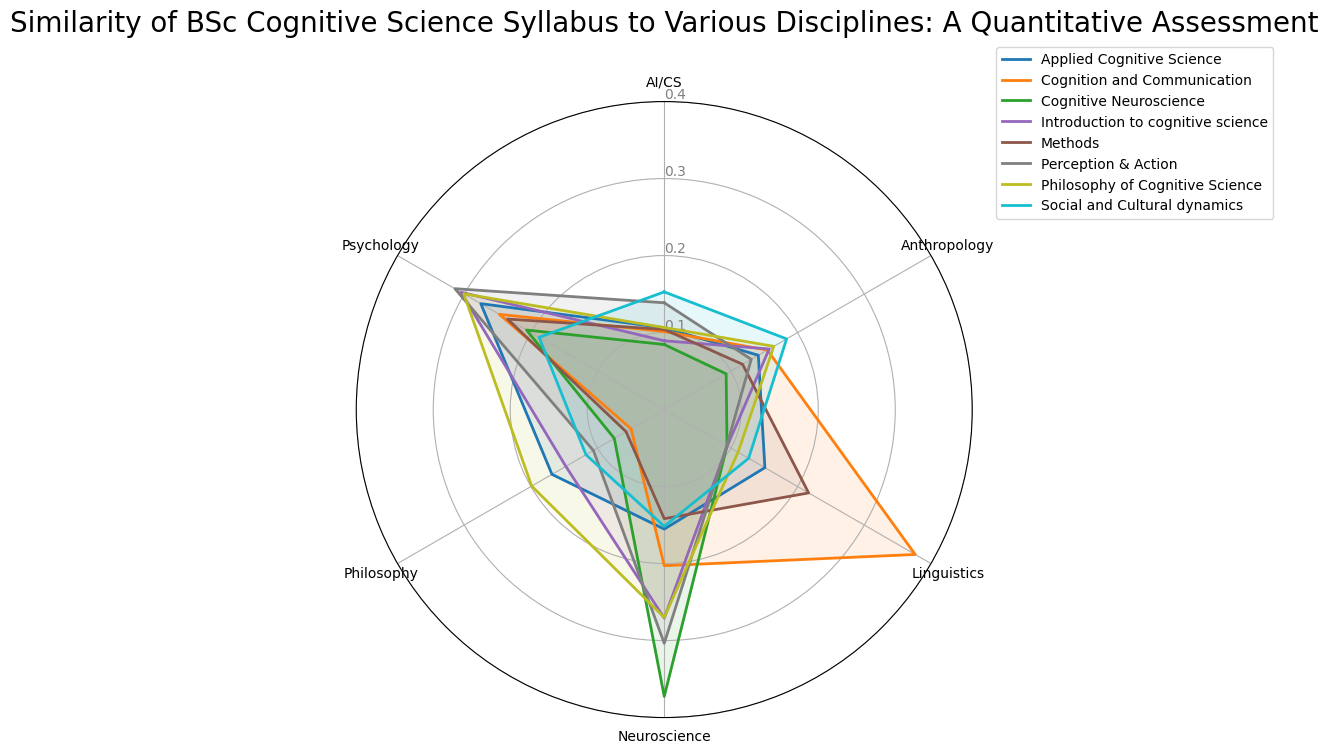

In [84]:
import matplotlib.pyplot as plt

# Ensure topics are consistent across data
topics = sorted(all_df['topic'].unique())
num_vars = len(topics)

# Compute angles
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Completing the loop

# Initialize radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Setup the axes
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_rlabel_position(0)

# Set ticks for topics and R-axis labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(topics)
ax.set_yticks([0.1, 0.2, 0.3, 0.4])
ax.set_yticklabels(["0.1", "0.2", "0.3", "0.4"], color="grey", size=10)
ax.set_ylim(0, 0.4)


# Create a more contrasting color map using 'inferno'
colors = plt.cm.tab10(np.linspace(0, 1, all_df['course'].nunique()))

# Plot each course's data
for idx, (course, group) in enumerate(all_df.groupby('course')):
    # Ensure all topics are included, missing ones filled with 0
    values = group.set_index('topic')['score'].reindex(topics, fill_value=0).tolist()
    values += values[:1]  # Complete the loop
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=course, color=colors[idx])
    ax.fill(angles, values, alpha=0.1, color=colors[idx])
    #ax.scatter(angles, values, s=50, zorder=10, color=colors[idx])

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.1))

# Show the radar chart
plt.title('Similarity of BSc Cognitive Science Syllabus to Various Disciplines: A Quantitative Assessment', size=20, color='black', y=1.1)
plt.show()


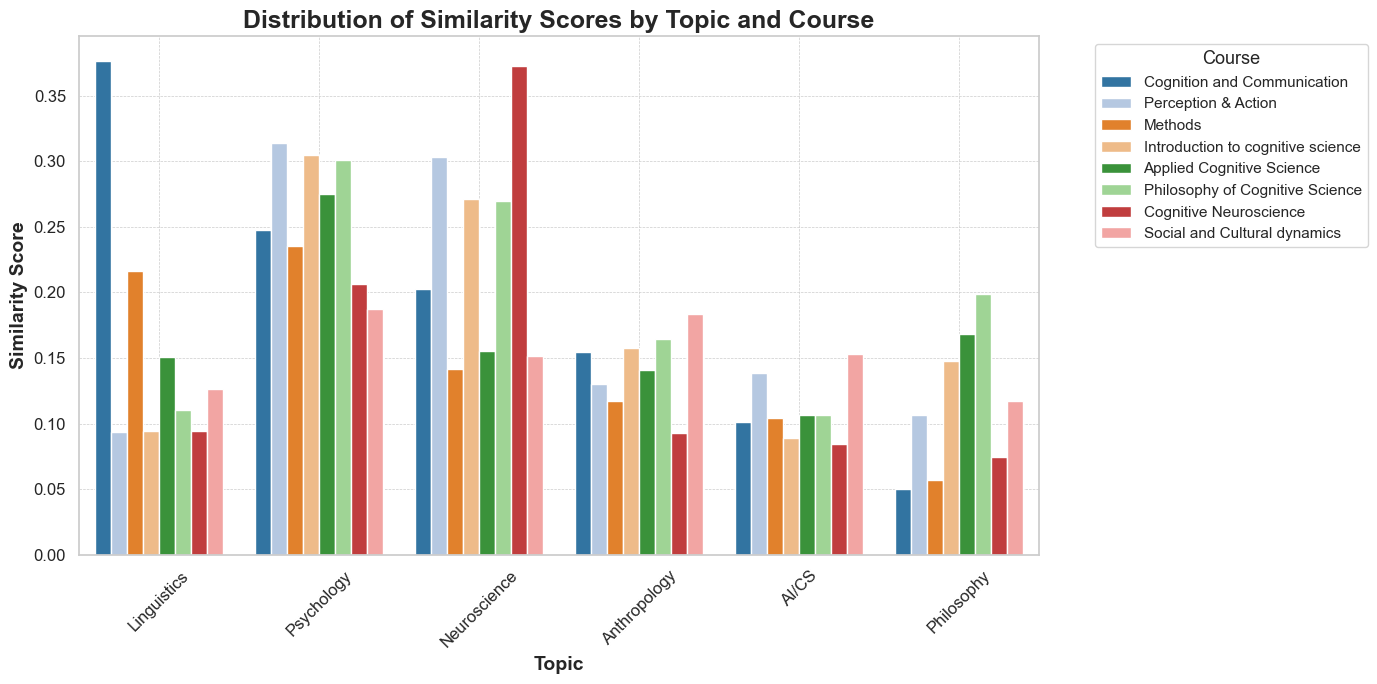

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming all_df is already defined and contains the relevant data
# Set the theme to a minimalistic one
sns.set_theme(style="whitegrid")

# Create the bar plot with an enhanced color palette and adjusted size
plt.figure(figsize=(14, 7))
sns.barplot(x='topic', y='score', hue='course', data=all_df, palette="tab20")

# Title and labels
plt.title('Distribution of Similarity Scores by Topic and Course', fontsize=18, weight='bold')
plt.xlabel('Topic', fontsize=14, weight='bold')
plt.ylabel('Similarity Score', fontsize=14, weight='bold')

# Enhance the legend
plt.legend(title='Course', title_fontsize='13', fontsize='11', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add a grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Improve axis ticks and labels
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()
